In [2]:
import numpy as np
from scipy.stats import unitary_group
from scipy.special import factorial
from opt_einsum import contract

import random
from random import choices

from functools import partial
from itertools import product, combinations, combinations_with_replacement

import tensorcircuit as tc
import qutip as qt

import jax
import jax.numpy as jnp
import jax.random as jrand

from restrict_haar_theory import rstHaarUnitary

import time
import os

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=25)
rc('axes', linewidth=3)
rc('text.latex', preamble=r'\usepackage{amsfonts}')

K = tc.set_backend('jax')
tc.set_dtype('complex128')

Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


('complex128', 'float64')

In [202]:
def label2Pauli(label):
    # transform a string to a Pauli operator
    paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    if type(label)==int:
        P = paulis[label]
    else:
        P = qt.tensor([paulis[x] for x in label])
    return P

def circuitBlockPrepare(n, L):
    # generate the Paulis and entangling layers unitary using in RPA
    random.seed(22)
    Pauligroup = list(product(range(1,4), repeat=n))
    Plabels = np.array(choices(Pauligroup, k=L), dtype=int)
    np.random.seed(22)
    Ws = unitary_group.rvs(dim=2**n, size=L)
    return Plabels, Ws

In [114]:
def RPA_ypred(weights, input, n, Xs, Ws):
    L = len(weights)
    c = tc.Circuit(n, inputs=input)
    for l in range(L):
        c.exp1(*range(n), theta=weights[l], hermitian=Xs[l], half=True)
        c.any(*range(n), unitary=Ws[l])
    return K.real(c.expectation((tc.gates.z(), [0])))

In [203]:
def RPA_outputFid(weights, input, m, n, Xs, Ws):
    L = len(weights)
    c = tc.Circuit(n, inputs=input)
    for l in range(L):
        c.exp1(*range(n), theta=weights[l], hermitian=Xs[l], half=True)
        c.any(*range(n), unitary=Ws[l])
    return (K.abs(c.state()[m])**2).squeeze()

def RPA_outputState(weights, input, n, Xs, Ws):
    L = len(weights)
    c = tc.Circuit(n, inputs=input)
    for l in range(L):
        c.exp1(*range(n), theta=weights[l], hermitian=Xs[l], half=True)
        c.any(*range(n), unitary=Ws[l])
    return c.state()

def circuitU(weights, n, Xs, Ws):
    L = len(weights)
    c = tc.Circuit(n, inputs=np.eye(2**n))
    for l in range(L):
        c.exp1(*range(n), theta=weights[l], hermitian=Xs[l], half=True)
        c.any(*range(n), unitary=Ws[l])
    return c.wavefunction().reshape(2**n, 2**n)

In [ ]:
def RPAtraining_ypred(n, L, batch, eta, steps, data, targets, intercept=100, display_time=100):
    ndata = len(targets)
    
    key = jrand.PRNGKey(42)
    thetas = jrand.uniform(key, shape=(batch, L))*(2.*np.pi)

    labels, Ws = circuitBlockPrepare(n, L)
    Xs = [label2Pauli(x).full() for x in labels]

    ypred_vag = K.jit(K.value_and_grad(partial(RPA_ypred, n=n, Xs=Xs, Ws=Ws)))
    ypred_vvag = K.jit(K.vmap(ypred_vag, vectorized_argnums=1))
    ypred_vvag_batch = K.jit(K.vmap(ypred_vvag, vectorized_argnums=0))

    eps_hist = jnp.zeros((steps, batch, ndata))
    thetas_hist = jnp.zeros((steps//intercept+1, batch, L))
    
    t0 = time.time()
    for step in range(steps):
        ys, Js = ypred_vvag_batch(thetas, data)
        epss = ys - targets

        grad_loss = contract('ra, rai->ri', epss, Js)/ndata
        
        eps_hist = eps_hist.at[step].set(epss)

        if step % intercept == 0:
            thetas_hist = thetas_hist.at[step//intercept].set(thetas)

        thetas = thetas - eta* grad_loss
        if step % display_time == 0:
            print(f"Step {step}, time elapsed: {time.time()-t0} seconds")
    
    return eps_hist, thetas_hist

In [39]:
def RPAtraining_state(n, L, batch, eta, steps, data, Ms, Ftargets, intercept=100, display_time=100):
    ndata = len(Ftargets)

    key = jrand.PRNGKey(42)
    thetas = jrand.uniform(key, shape=(batch, L))*(2.*np.pi)

    labels, Ws = circuitBlockPrepare(n, L)
    Xs = [label2Pauli(x).full() for x in labels]

    fid_vag = K.jit(K.value_and_grad(partial(RPA_outputFid, n=n, Xs=Xs, Ws=Ws)))
    fid_vvag = K.jit(K.vmap(fid_vag, vectorized_argnums=(1, 2)))
    fid_vvag_batch = K.jit(K.vmap(fid_vvag, vectorized_argnums=0))

    eps_hist = jnp.zeros((steps, batch, ndata))
    K_hist = jnp.zeros((steps, batch, ndata, ndata))
    thetas_hist = jnp.zeros((steps//intercept+1, batch, L))

    t0 = time.time()
    for step in range(steps):
        Fs, Js = fid_vvag_batch(thetas, data, Ms)
        epss = Fs - Ftargets
        
        grad_loss = contract('ra, rai->ri', epss, Js)/ndata
        
        eps_hist = eps_hist.at[step].set(epss)
        Ks = contract('rai, rbi->rab', Js, Js)
        K_hist = K_hist.at[step].set(Ks)

        if step % intercept == 0:
            thetas_hist = thetas_hist.at[step//intercept].set(thetas)
        
        thetas = thetas - eta* grad_loss

        if step % display_time == 0:
            print(f'step={step}, eps={epss}, time={time.time() - t0} seconds')
    
    return eps_hist, K_hist, thetas_hist

In [ ]:
def hessianCal(thetas, data, Ms, n, L):
    labels, Ws = circuitBlockPrepare(n, L)
    Xs = [label2Pauli(x).full() for x in labels]

    fid_g = K.jit(K.grad(partial(RPA_outputFid, n=n, Xs=Xs, Ws=Ws)))
    fid_h = K.jit(jax.jacfwd(fid_g))
    fid_vh = K.jit(K.vmap(fid_h, vectorized_argnums=(1, 2)))
    fid_vh_batch = K.jit(K.vmap(fid_vh, vectorized_argnums=0))

    return fid_vh_batch(thetas, data, Ms)

In [4]:
def ldaReduceCal(Ks, mus):
    # lda_{a a b}
    ndata = Ks.shape[1]
    ldas = np.zeros((len(Ks), ndata, ndata))
    for (i, j) in product(range(ndata), repeat=2):
        ldas[:, i, j] = mus[:, i, i, j] / np.sqrt(Ks[:, i, i] * Ks[:, j, j])
    return ldas

In [4]:
def rstU(d, Ndata, num):
    '''
    restricted Haar unitary ensemble
    true label can only be \pm 1; the number of data in each class is same
    '''
    np.random.seed()
    Us = np.zeros((num, d, d), dtype=np.complex128)
    if Ndata < d-1:
        Us[:, np.arange(Ndata), np.arange(Ndata)] = np.exp(1j*np.random.uniform(0, 2*np.pi, (num, Ndata)))
        Us[:, Ndata:, Ndata:] = unitary_group.rvs(dim=d-Ndata, size=num)
    else:
        Us[:, range(d), range(d)] = np.exp(1j*np.random.uniform(0, 2*np.pi, (num, d)))
    return Us

In [5]:
def ensembleProductTr(V, Us, K):
    res = contract('ij, aji->a', V.conj().T, Us)
    return jnp.sum(jnp.abs(res)**(2 * K))

framePotCal = jax.jit(jax.vmap(ensembleProductTr, in_axes=(0, None, None)))

In [8]:
def framePotLB_rstHaar(Ndata, K, d):
    F = 0
    if Ndata < d-1:
        for k1 in range(0, K+1, 2):
            for k2 in range(0, K-k1+1):
                coeff = factorial(K)/(factorial(k1//2)**2*factorial(k2)*factorial(K-k1-k2))* \
                    Ndata**(K - k1 - k2)
                F += coeff* factorial(k1//2 + k2)
    else:
        for k1 in range(0, K+1, 2):
            F += factorial(K)/(factorial(k1//2)**2*factorial(K-k1)) * d**(K - k1)
    return F

In [ ]:
n = 4
L = 160
ndata = 2
batch = 3

np.random.seed(42)
U = unitary_group.rvs(2**n)
inputs = jnp.array(U[:, :ndata].T)
Ms = np.array([0, 1]).reshape(2,1)

Ftargets = jnp.array([4, 4])

res = RPAtraining(n, L, batch, 0.001, steps, inputs, Ms, Ftargets, intercept=8000)

In [262]:
n = 4
L = 384
y1, y2 = 5, 6

np.random.seed(42)
U = unitary_group.rvs(2**n)
inputs = jnp.array(U[:, :ndata].T)

labels, Ws = circuitBlockPrepare(n, L)
Xs = [label2Pauli(x).full() for x in labels]

output_vmap = K.jit(K.vmap(partial(RPA_outputState, n=n, Xs=Xs, Ws=Ws), vectorized_argnums=1))
output_vmap_batch = K.jit(K.vmap(output_vmap))

thetas = np.load(f'data/rstHaar/n{n}/L{L}/RPASpthetahist_n{n}L{L}_{y1}_{y2}.npy')[-1]

states = output_vmap_batch(thetas, inputs)

np.save(f'data/rstHaar/n{n}/L{L}/RPASpstates_n{n}L{L}_{y1}_{y2}.npy', states)

# Ensemble average of $K$

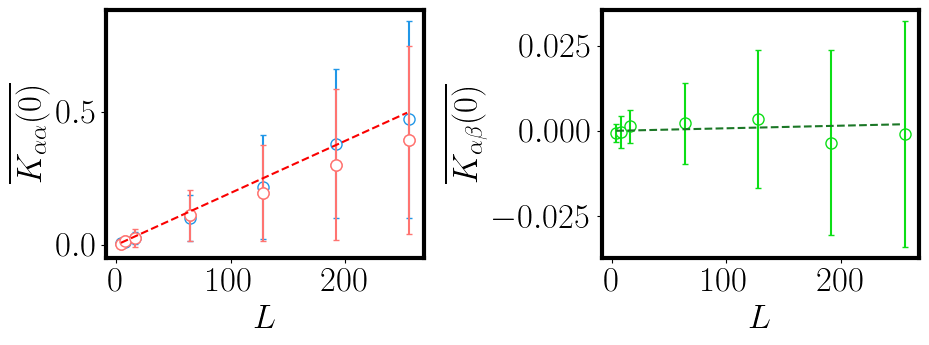

In [51]:
# haar ensemble
n = 4
d = 2**n
Ls = [4, 8, 16, 64, 128, 192, 256]
ndata = 2
batch = 50
y1, y2 = 0.5, 0.5

Ks = np.zeros((len(Ls), batch, ndata, ndata))
for i in range(len(Ls)):
    Ks[i] = np.load(f'data/Haar/n{n}/RPASpK0_n{n}L{Ls[i]}_{y1}_{y2}.npy')

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
Lss = np.arange(4, 255)
clk = ['#2197E7', '#0CDE16', '#FF7471']
clk2 = ['#262BEE', '#1B7726', '#FA0000']
for i in range(2):
    axs[0].errorbar(Ls, np.mean(Ks[:, :, i, i], axis=1), yerr=np.std(Ks[:, :, i, i], axis=1), 
        fmt='o', mfc='white', markersize=8, c=clk[2*i], barsabove=True, capsize=2)
axs[0].plot(Ls, np.mean(Ks[:, :, 1, 1], axis=1), 'o', mfc='white', markersize=8, c=clk[2])
axs[0].plot(Lss, Lss/(2*d**2), '--', c=clk2[2])
axs[0].set_xlabel(r'$L$')
axs[0].set_ylabel(r'$\overline{K_{\alpha \alpha}(0)}$')

axs[1].errorbar(Ls, np.mean(Ks[:, :, 0, 1], axis=1), yerr=np.std(Ks[:, :, 0, 1], axis=1), 
    fmt='o', mfc='white', markersize=8, c=clk[1], barsabove=True, capsize=2)
axs[1].plot(Lss, Lss/(2*d**4), '--', c=clk2[1])
axs[1].set_xlabel(r'$L$')
axs[1].set_ylabel(r'$\overline{K_{\alpha \beta}(0)}$')

plt.tight_layout()

In [222]:
n = 3
y1, y2 = 0.5, 0.6
L = 320
Hs = np.load(f'data/rstHaar/n{n}/L{L}/RPASpHend_n{n}L{L}_{y1}_{y2}.npy')
Js = np.load(f'data/rstHaar/n{n}/L{L}/RPASpJend_n{n}L{L}_{y1}_{y2}.npy')
Ks = contract('rai, rbi->rab', Js, Js)
mus = contract('rai, rbij, rcj->rabc', Js, Hs, Js)

np.save(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{y1}_{y2}.npy', Ks)
np.save(f'data/rstHaar/n{n}/L{L}/RPASpMuend_n{n}L{L}_{y1}_{y2}.npy', mus)

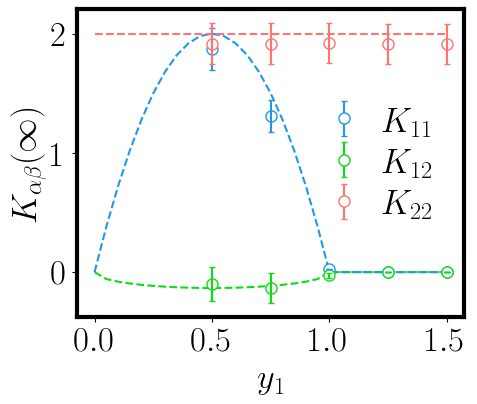

In [26]:
# restricted haar ensemble
n = 4
d = 2**n
L = 256
ndata = 2
batch = 100
y1list = np.arange(0.5, 1.6, 0.25)
y2 = 0.5

Ks = np.zeros((len(y1list), batch, ndata, ndata))
for i in range(len(y1list)):
    Ks[i] = np.load(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{y1list[i]}_{y2}.npy')

fig, ax = plt.subplots(figsize=(5, 4))
y1s = np.arange(0., 1.51, 0.05)
f1s = np.array([min(x, 1) for x in y1s])
f2 = 0.5
clk = ['#2197E7', '#0CDE16', '#FF7471']

for cc, (i, j) in enumerate(combinations_with_replacement(range(ndata), 2)):
    ax.errorbar(y1list, np.mean(Ks[:, :, i, j], axis=1), yerr=np.std(Ks[:, :, i, j], axis=1), 
        fmt='o', mfc='white', markersize=8, c=clk[cc], barsabove=True, capsize=2, label=fr'$K_{{{i+1} {j+1}}}$')
Koff_pred = -L*np.sqrt(f1s*f2*(1 - f1s)*(1 - f2))/(2*d*(d-1))
ax.plot(y1s, Koff_pred, '--', c=clk[1], zorder=1)
ax.plot(y1s, L*0.5*f1s*(1 - f1s)/d, '--', c=clk[0], zorder=1)
ax.plot(y1s, L*0.5*f2*(1 - f2)/d*np.ones_like(y1s), '--', c=clk[2], zorder=1)
ax.legend(framealpha=0, labelspacing=0.3, handletextpad=0.1, loc='center right')
ax.set_xlabel(r'$y_1$')
ax.set_ylabel(r'$K_{\alpha \beta}(\infty)$')
ax.set_xticks([0, 0.5, 1., 1.5])

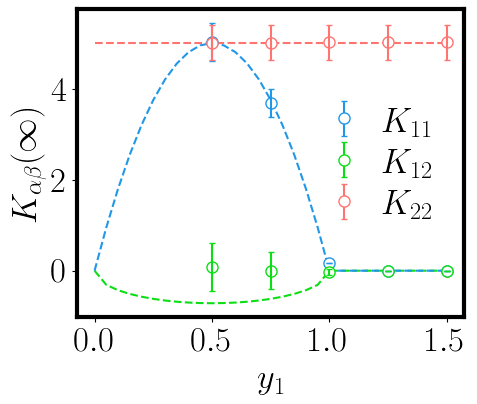

In [174]:
# restricted haar ensemble
n = 3
d = 2**n
L = 320
ndata = 2
batch = 100
y1list = np.arange(0.5, 1.6, 0.25)
y2 = 0.5

Ks = np.zeros((len(y1list), batch, ndata, ndata))
for i in range(len(y1list)):
    Ks[i] = np.load(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{y1list[i]}_{y2}.npy')

fig, ax = plt.subplots(figsize=(5, 4))
y1s = np.arange(0., 1.51, 0.05)
f1s = np.array([min(x, 1) for x in y1s])
f2 = 0.5
clk = ['#2197E7', '#0CDE16', '#FF7471']

for cc, (i, j) in enumerate(combinations_with_replacement(range(ndata), 2)):
    ax.errorbar(y1list, np.mean(Ks[:, :, i, j], axis=1), yerr=np.std(Ks[:, :, i, j], axis=1), 
        fmt='o', mfc='white', markersize=8, c=clk[cc], barsabove=True, capsize=2, label=fr'$K_{{{i+1} {j+1}}}$')
Koff_pred = -L*np.sqrt(f1s*f2*(1 - f1s)*(1 - f2))/(2*d*(d-1))
ax.plot(y1s, Koff_pred, '--', c=clk[1], zorder=1)
ax.plot(y1s, L*0.5*f1s*(1 - f1s)/d, '--', c=clk[0], zorder=1)
ax.plot(y1s, L*0.5*f2*(1 - f2)/d*np.ones_like(y1s), '--', c=clk[2], zorder=1)
ax.legend(framealpha=0, labelspacing=0.3, handletextpad=0.1, loc='center right')
ax.set_xlabel(r'$y_1$')
ax.set_ylabel(r'$K_{\alpha \beta}(\infty)$')
ax.set_xticks([0, 0.5, 1., 1.5])

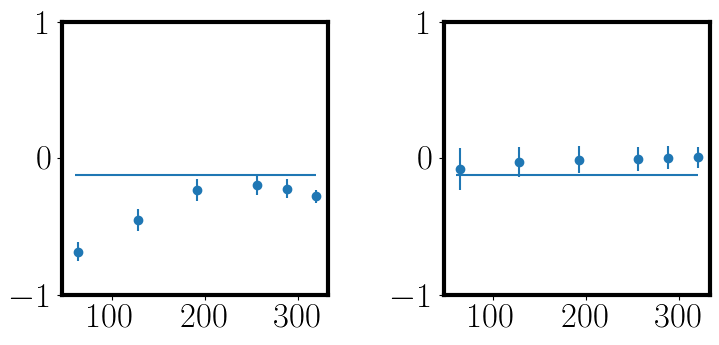

In [277]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

n = 3
Ls = np.array([64, 128, 192, 256, 288, 320])
y1, y2 = 5, 6
Bs = np.zeros((len(Ls), 400))
for i, L in enumerate(Ls):
    Ks = np.load(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{y1}_{y2}.npy')
    Bs[i] = Ks[:, 0, 1]/np.sqrt(Ks[:, 0, 0] * Ks[:, 1, 1])
axs[0].errorbar(Ls, np.mean(Bs, axis=1), yerr=np.std(Bs, axis=1), fmt='o')
axs[0].hlines(-1/2**n, xmin=60, xmax=320)
axs[0].set_ylim(-1, 1)

n = 3
y1, y2 = 0.5, 0.6
Bs = np.zeros((len(Ls), 400))
for i, L in enumerate(Ls):
    Ks = np.load(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{y1}_{y2}.npy')
    Bs[i] = Ks[:, 0, 1]/np.sqrt(Ks[:, 0, 0] * Ks[:, 1, 1])
axs[1].errorbar(Ls, np.mean(Bs, axis=1), yerr=np.std(Bs, axis=1), fmt='o')
axs[1].hlines(-1/2**n, xmin=60, xmax=320)
axs[1].set_ylim(-1, 1)
plt.tight_layout()

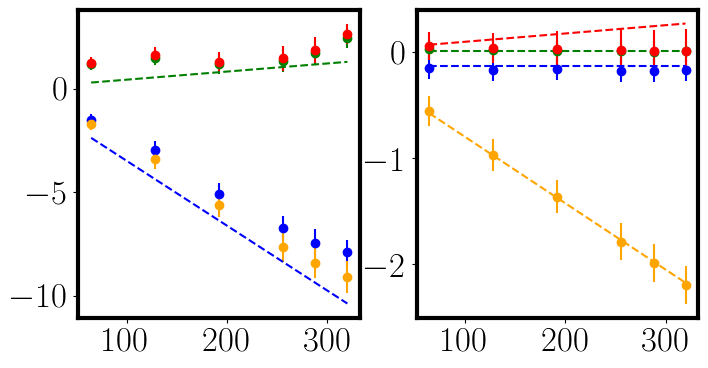

In [273]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

n = 3
d = 2**n
Ls = np.array([64, 128, 192, 256, 288, 320])
y1, y2 = 5, 6
ldas = np.zeros((len(Ls), 400, ndata, ndata))
for i, L in enumerate(Ls):
    mus = np.load(f'data/rstHaar/n{n}/L{L}/RPASpMuend_n{n}L{L}_{y1}_{y2}.npy')
    Ks = np.load(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{y1}_{y2}.npy')
    ldas[i] = ldaReduceCal(Ks, mus)
axs[0].errorbar(Ls, np.mean(ldas[:, :, 0, 0], axis=1), yerr=np.std(ldas[:, :, 0, 0], axis=1), fmt='o', c='b')
axs[0].errorbar(Ls, np.mean(ldas[:, :, 1, 1], axis=1), yerr=np.std(ldas[:, :, 1, 1], axis=1), fmt='o', c='orange')
axs[0].errorbar(Ls, np.mean(ldas[:, :, 0, 1], axis=1), yerr=np.std(ldas[:, :, 0, 1], axis=1), fmt='o', c='g')
axs[0].errorbar(Ls, np.mean(ldas[:, :, 1, 0], axis=1), yerr=np.std(ldas[:, :, 1, 0], axis=1), fmt='o', c='r')
axs[0].plot(Ls, -(2*(d*1 - 2) + Ls*(2*1 - 1))/(4*d), '--', c='b')
axs[0].plot(Ls, (2*(d*1 - 2) + Ls*(2*1 - 1))/(4*d**2), '--', c='g')


n = 3
d = 2**n
Ls = np.array([64, 128, 192, 256, 288, 320])
y1, y2 = 0.5, 0.6
ldas = np.zeros((len(Ls), 400, ndata, ndata))
for i, L in enumerate(Ls):
    mus = np.load(f'data/rstHaar/n{n}/L{L}/RPASpMuend_n{n}L{L}_{y1}_{y2}.npy')
    Ks = np.load(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{y1}_{y2}.npy')
    ldas[i] = ldaReduceCal(Ks, mus)
axs[1].errorbar(Ls, np.mean(ldas[:, :, 0, 0], axis=1), yerr=np.std(ldas[:, :, 0, 0], axis=1), fmt='o', c='b')
axs[1].errorbar(Ls, np.mean(ldas[:, :, 1, 1], axis=1), yerr=np.std(ldas[:, :, 1, 1], axis=1), fmt='o', c='orange')
axs[1].errorbar(Ls, np.mean(ldas[:, :, 0, 1], axis=1), yerr=np.std(ldas[:, :, 0, 1], axis=1), fmt='o', c='g')
axs[1].errorbar(Ls, np.mean(ldas[:, :, 1, 0], axis=1), yerr=np.std(ldas[:, :, 1, 0], axis=1), fmt='o', c='r')
axs[1].plot(Ls, -(2*(d*0.5 - 2) + Ls*(2*0.5 - 1))/(4*d), '--', c='b')
axs[1].plot(Ls, -(2*(d*0.6 - 2) + Ls*(2*0.6 - 1))/(4*d), '--', c='orange')
axs[1].plot(Ls, (2*(d*0.5 - 2) + Ls*(2*0.5 - 1))/(4*d**2), '--', c='g')
axs[1].plot(Ls, (2*(d*0.6 - 2) + Ls*(2*0.6 - 1))/(4*d**2), '--', c='r')

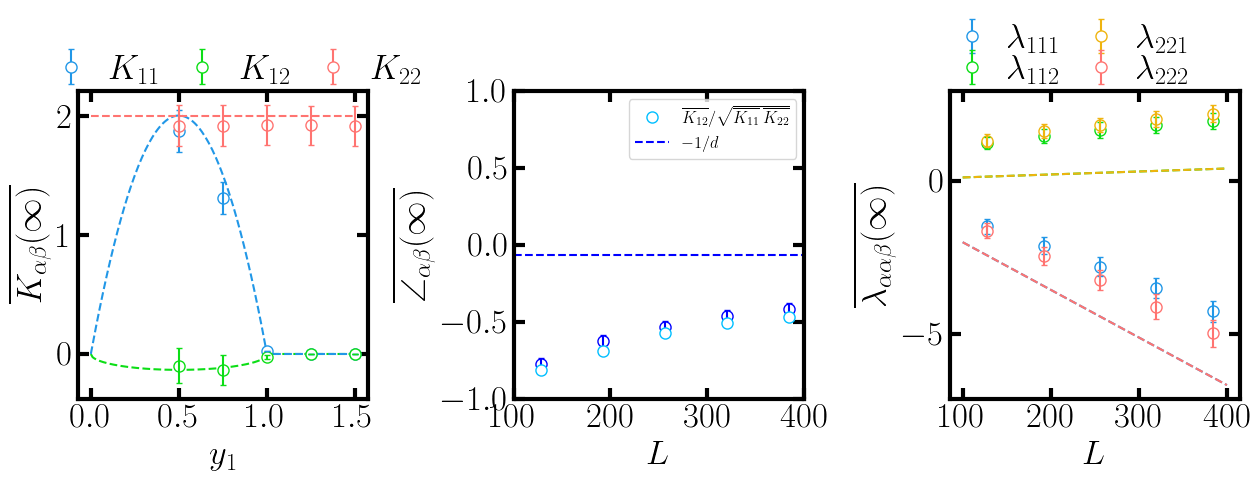

In [171]:
ndata = 2

y1list = np.arange(0.5, 1.6, 0.25)
Ks = np.zeros((len(y1list), 100, ndata, ndata))
for i in range(len(y1list)):
    Ks[i] = np.load(f'data/rstHaar/n{4}/L{256}/RPASpKend_n{4}L{256}_{y1list[i]}_0.5.npy')

n = 4
Llist = np.array([128, 192, 256, 320, 384])
Ks2 = np.zeros((len(Llist), 400, ndata, ndata))
ldas = np.zeros((len(Llist), 400, ndata, ndata))
ts2 = np.zeros((len(Llist), 400, ndata, ndata), dtype=complex)
for i in range(len(Llist)):
    L = Llist[i]
    Ks2[i] = np.load(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{5}_{6}.npy')
    mus = np.load(f'data/rstHaar/n{n}/L{L}/RPASpMuend_n{n}L{L}_{5}_{6}.npy')
    ldas[i] = ldaReduceCal(Ks2[i], mus)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# K vs y1
d = 2**4
f1s = np.array([min(x, 1) for x in np.arange(0, 1.51, 0.01)])
f2 = 0.5
cl1 = ['#2197E7', '#0CDE16', '#FF7471']
for cc, (i, j) in enumerate(combinations_with_replacement(range(ndata), 2)):
    axs[0].errorbar(y1list, np.mean(Ks[:, :, i, j], axis=1), yerr=np.std(Ks[:, :, i, j], axis=1), 
        fmt='o', mfc='white', markersize=8, c=cl1[cc], barsabove=True, capsize=2, label=fr'$K_{{{i+1} {j+1}}}$')
Koff_pred = -256*np.sqrt(f1s*f2*(1 - f1s)*(1 - f2))/(2*d*(d-1))
axs[0].plot(np.arange(0, 1.51, 0.01), Koff_pred, '--', c=cl1[1], zorder=1)
axs[0].plot(np.arange(0, 1.51, 0.01), 256*0.5*f1s*(1 - f1s)/d, '--', c=cl1[0], zorder=1)
axs[0].plot(np.arange(0, 1.51, 0.01), 256*0.5*f2*(1 - f2)/d*np.ones(len(f1s)), '--', c=cl1[2], zorder=1)
axs[0].legend(framealpha=0, labelspacing=0, handletextpad=0.1, ncol=3, columnspacing=0.2, loc='upper left',
    bbox_to_anchor=(-0.25, 1.22))
axs[0].set_xlabel(r'$y_1$')
axs[0].set_ylabel(r'$\overline{K_{\alpha \beta}(\infty)}$')
axs[0].set_xticks([0, 0.5, 1., 1.5])

# angle vs L
d = 2**4
fs = [1, 1]
Ls = np.arange(100, 401)
Bs = Ks2[:, :, 0, 1]/np.sqrt(Ks2[:, :, 0, 0]*Ks2[:, :, 1, 1])
axs[1].errorbar(Llist, np.mean(Bs, axis=1), yerr=np.std(Bs, axis=1), fmt='o', mfc='white', 
    markersize=8, barsabove=True, capsize=2, c='b')
axs[1].plot(Llist, np.mean(Ks2[:, :, 0, 1], axis=1)/np.sqrt(np.mean(Ks2[:, :, 0, 0], axis=1)
    *np.mean(Ks2[:, :, 1, 1], axis=1)), 'o', markersize=8, mfc='white', c='deepskyblue', 
    label=r'$\overline{K_{12}}/\sqrt{\overline{K_{11}}\:\overline{K_{22}}}$')

axs[1].plot(Ls, -1/d*np.ones_like(Ls), '--', c='b', label=r'$-1/d$')
axs[1].legend(fontsize=12, loc='upper right')
axs[1].set_xlabel(r'$L$')
axs[1].set_ylabel(r'$\overline{\angle_{\alpha \beta} (\infty)}$')
axs[1].set_xticks([100, 200, 300, 400])
axs[1].set_xlim(100, 400)
axs[1].set_ylim(-1, 1)

# lambda vs L
d = 2**4
cl2 = ['#2197E7', '#0CDE16', '#EFB40F', '#FF7471']
for cc, (i, j) in enumerate(product(range(ndata), repeat=2)):
    axs[2].errorbar(Llist, np.mean(ldas[:, :, i, j], axis=1), yerr=np.std(ldas[:, :, i, j], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl2[cc], label=fr'$\lambda_{{{i+1}{i+1}{j+1}}}$')
lda1_pred = -(2*(d*fs[0] - 2) + Ls*(2*fs[0] - 1))/(4*d)
lda2_pred = -(2*(d*fs[1] - 2) + Ls*(2*fs[1] - 1))/(4*d)
axs[2].plot(Ls, lda1_pred, '--', c=cl2[0])
axs[2].plot(Ls, lda2_pred, '--', c=cl2[-1])
lda12_pred = (2*(d*fs[0] - 2) + Ls*(2*fs[0] - 1))/(4*d**2)
lda21_pred = (2*(d*fs[1] - 2) + Ls*(2*fs[1] - 1))/(4*d**2)
axs[2].plot(Ls, lda12_pred, '--', c=cl2[1])
axs[2].plot(Ls, lda21_pred, '--', c=cl2[2])
axs[2].legend(framealpha=0, labelspacing=0., handletextpad=0., ncol=2, columnspacing=0.2, loc='upper left',
    bbox_to_anchor=(-0.15, 1.32))
axs[2].set_xlabel(r'$L$')
axs[2].set_ylabel(r'$\overline{\lambda_{\alpha \alpha \beta} (\infty)}$')
axs[2].set_xticks([100, 200, 300, 400])

for i in range(3):
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')
plt.subplots_adjust(wspace=0.5)

# fig.text(0.13, 0.78, r'$\rm (a)$')
# fig.text(0.42, 0.78, r'$\rm (b)$')
# fig.text(0.7, 0.78, r'$\rm (c)$')

#plt.savefig('figures/Uaverage.pdf', bbox_inches='tight')
plt.show()
plt.close()

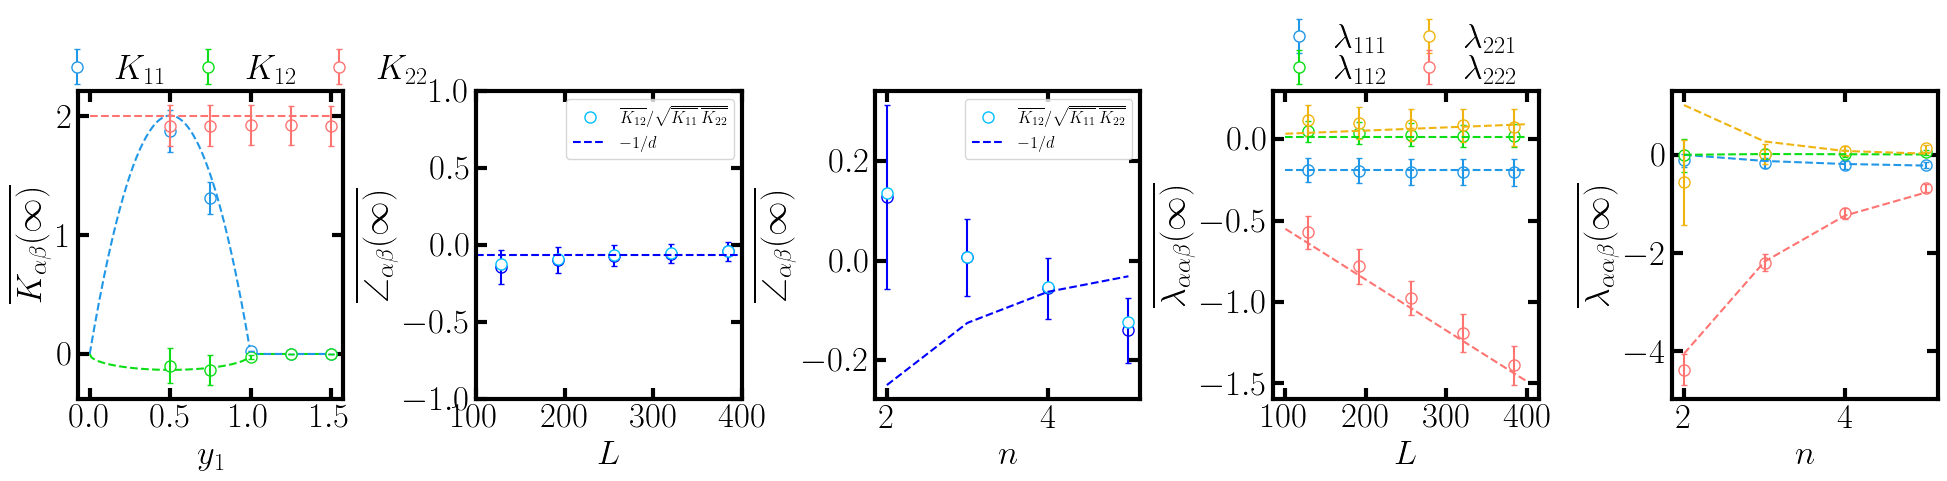

In [170]:
ndata = 2
y1list = np.arange(0.5, 1.6, 0.25)
Ks = np.zeros((len(y1list), 100, ndata, ndata))
for i in range(len(y1list)):
    Ks[i] = np.load(f'data/rstHaar/n{4}/L{256}/RPASpKend_n{4}L{256}_{y1list[i]}_0.5.npy')

n = 4
Llist = np.array([128, 192, 256, 320, 384])
Ks2 = np.zeros((len(Llist), 400, ndata, ndata))
ldas2 = np.zeros((len(Llist), 400, ndata, ndata))
for i in range(len(Llist)):
    L = Llist[i]
    Ks2[i] = np.load(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{0.5}_{0.6}.npy')
    mus = np.load(f'data/rstHaar/n{n}/L{L}/RPASpMuend_n{n}L{L}_{0.5}_{0.6}.npy')
    ldas2[i] = ldaReduceCal(Ks2[i], mus)

L = 320
nlist = np.array([2, 3, 4, 5])
Ks3 = np.zeros((len(nlist), 400, ndata, ndata))
ldas3 = np.zeros((len(nlist), 400, ndata, ndata))
for i in range(len(nlist)):
    n = nlist[i]
    Ks3[i] = np.load(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{0.5}_{0.6}.npy')
    mus = np.load(f'data/rstHaar/n{n}/L{L}/RPASpMuend_n{n}L{L}_{0.5}_{0.6}.npy')
    ldas3[i] = ldaReduceCal(Ks3[i], mus)
    

fig, axs = plt.subplots(1, 5, figsize=(24, 4))

# K vs y1
d = 2**4
f1s = np.array([min(x, 1) for x in np.arange(0, 1.51, 0.01)])
f2 = 0.5
cl1 = ['#2197E7', '#0CDE16', '#FF7471']
for cc, (i, j) in enumerate(combinations_with_replacement(range(ndata), 2)):
    axs[0].errorbar(y1list, np.mean(Ks[:, :, i, j], axis=1), yerr=np.std(Ks[:, :, i, j], axis=1), 
        fmt='o', mfc='white', markersize=8, c=cl1[cc], barsabove=True, capsize=2, label=fr'$K_{{{i+1} {j+1}}}$')
Koff_pred = -256*np.sqrt(f1s*f2*(1 - f1s)*(1 - f2))/(2*d*(d-1))
axs[0].plot(np.arange(0, 1.51, 0.01), Koff_pred, '--', c=cl1[1], zorder=1)
axs[0].plot(np.arange(0, 1.51, 0.01), 256*0.5*f1s*(1 - f1s)/d, '--', c=cl1[0], zorder=1)
axs[0].plot(np.arange(0, 1.51, 0.01), 256*0.5*f2*(1 - f2)/d*np.ones(len(f1s)), '--', c=cl1[2], zorder=1)
axs[0].legend(framealpha=0, labelspacing=0, handletextpad=0.1, ncol=3, columnspacing=0.2, loc='upper left',
    bbox_to_anchor=(-0.25, 1.22))
axs[0].set_xlabel(r'$y_1$')
axs[0].set_ylabel(r'$\overline{K_{\alpha \beta}(\infty)}$')
axs[0].set_xticks([0, 0.5, 1., 1.5])

# angle vs L
d = 2**4
Ls = np.arange(100, 401)
fs = [0.5, 0.6]
Bs = Ks2[:, :, 0, 1]/np.sqrt(Ks2[:, :, 0, 0]*Ks2[:, :, 1, 1])
axs[1].errorbar(Llist, np.mean(Bs, axis=1), yerr=np.std(Bs, axis=1), fmt='o', mfc='white', 
    markersize=8, barsabove=True, capsize=2, c='b')
axs[1].plot(Llist, np.mean(Ks2[:, :, 0, 1], axis=1)/(Llist/(2*d) * np.sqrt(fs[0]*fs[1]*(1-fs[0])*(1-fs[1]))), 
    'o', markersize=8, mfc='white', c='deepskyblue', label=r'$\overline{K_{12}}/\sqrt{\overline{K_{11}}\:\overline{K_{22}}}$')
axs[1].plot(Ls, -1/d*np.ones_like(Ls), '--', c='b', label=r'$-1/d$')
axs[1].legend(fontsize=12, loc='upper right')
axs[1].set_xlabel(r'$L$')
axs[1].set_ylabel(r'$\overline{\angle_{\alpha \beta} (\infty)}$')
axs[1].set_xticks([100, 200, 300, 400])
axs[1].set_xlim(100, 400)
axs[1].set_ylim(-1, 1)

# angle vs n
L = 320
Bs = Ks3[:, :, 0, 1]/np.sqrt(Ks3[:, :, 0, 0]*Ks3[:, :, 1, 1])
axs[2].errorbar(nlist, np.mean(Bs, axis=1), yerr=np.std(Bs, axis=1), fmt='o', mfc='white', 
    markersize=8, barsabove=True, capsize=2, c='b')
axs[2].plot(nlist, np.mean(Ks3[:, :, 0, 1], axis=1)/(L/(2*2**nlist) * np.sqrt(fs[0]*fs[1]*(1-fs[0])*(1-fs[1]))), 
    'o', markersize=8, mfc='white', c='deepskyblue', label=r'$\overline{K_{12}}/\sqrt{\overline{K_{11}}\:\overline{K_{22}}}$')
axs[2].plot(nlist, -1/2**nlist, '--', c='b', label=r'$-1/d$')
axs[2].legend(fontsize=12, loc='upper right')
axs[2].set_xlabel(r'$n$')
axs[2].set_ylabel(r'$\overline{\angle_{\alpha \beta} (\infty)}$')

cl2 = ['#2197E7', '#0CDE16', '#EFB40F', '#FF7471']
for cc, (i, j) in enumerate(product(range(ndata), repeat=2)):
    axs[3].errorbar(Llist, np.mean(ldas2[:, :, i, j], axis=1), yerr=np.std(ldas2[:, :, i, j], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl2[cc], label=fr'$\lambda_{{{i+1}{i+1}{j+1}}}$')
lda1_pred = -(2*(d*fs[0] - 2) + Ls*(2*fs[0] - 1))/(4*d)
lda2_pred = -(2*(d*fs[1] - 2) + Ls*(2*fs[1] - 1))/(4*d)
axs[3].plot(Ls, lda1_pred, '--', c=cl2[0])
axs[3].plot(Ls, lda2_pred, '--', c=cl2[-1])
lda12_pred = (2*(d*fs[0] - 2) + Ls*(2*fs[0] - 1))/(4*d**2)
lda21_pred = (2*(d*fs[1] - 2) + Ls*(2*fs[1] - 1))/(4*d**2)
axs[3].plot(Ls, lda12_pred, '--', c=cl2[1])
axs[3].plot(Ls, lda21_pred, '--', c=cl2[2])
axs[3].legend(framealpha=0, labelspacing=0., handletextpad=0., ncol=2, columnspacing=0.2, loc='upper left',
    bbox_to_anchor=(-0.15, 1.32))
axs[3].set_xlabel(r'$L$')
axs[3].set_ylabel(r'$\overline{\lambda_{\alpha \alpha \beta} (\infty)}$')
axs[3].set_xticks([100, 200, 300, 400])

for cc, (i, j) in enumerate(product(range(ndata), repeat=2)):
    axs[4].errorbar(nlist, np.mean(ldas3[:, :, i, j], axis=1), yerr=np.std(ldas3[:, :, i, j], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl2[cc], label=fr'$\lambda_{{{i+1}{i+1}{j+1}}}$')
lda1_pred = -(2*(2**nlist*fs[0] - 2) + L*(2*fs[0] - 1))/(4*2**nlist)
lda2_pred = -(2*(2**nlist*fs[1] - 2) + L*(2*fs[1] - 1))/(4*2**nlist)
axs[4].plot(nlist, lda1_pred, '--', c=cl2[0])
axs[4].plot(nlist, lda2_pred, '--', c=cl2[-1])
lda12_pred = (2*(2**nlist*fs[0] - 2) + L*(2*fs[0] - 1))/(4*4**nlist)
lda21_pred = (2*(2**nlist*fs[1] - 2) + L*(2*fs[1] - 1))/(4*4**nlist)
axs[4].plot(nlist, lda12_pred, '--', c=cl2[1])
axs[4].plot(nlist, lda21_pred, '--', c=cl2[2])
axs[4].set_xlabel(r'$n$')
axs[4].set_ylabel(r'$\overline{\lambda_{\alpha \alpha \beta} (\infty)}$')

for i in range(5):
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')
plt.subplots_adjust(wspace=0.5)

# fig.text(0.13, 0.78, r'$\rm (a)$')
# fig.text(0.42, 0.78, r'$\rm (b)$')
# fig.text(0.7, 0.78, r'$\rm (c)$')

#plt.savefig('figures/Uaverage.pdf', bbox_inches='tight')
plt.show()
plt.close()

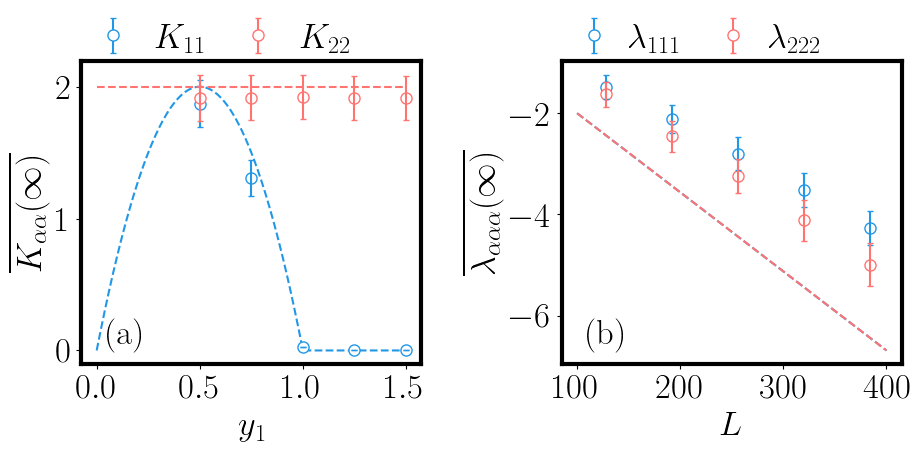

In [36]:
ndata = 2
y1list = np.arange(0.5, 1.6, 0.25)
Ks1 = np.zeros((len(y1list), 100, ndata, ndata))
for i in range(len(y1list)):
    Ks1[i] = np.load(f'data/rstHaar/n{4}/L{256}/RPASpKend_n{4}L{256}_{y1list[i]}_0.5.npy')

n = 4
Llist = np.array([128, 192, 256, 320, 384])
Ks2 = np.zeros((len(Llist), 400, ndata, ndata))
ldas2 = np.zeros((len(Llist), 400, ndata, ndata))
for i in range(len(Llist)):
    L = Llist[i]
    Ks2[i] = np.load(f'data/rstHaar/n{n}/L{L}/RPASpKend_n{n}L{L}_{5}_{6}.npy')
    mus = np.load(f'data/rstHaar/n{n}/L{L}/RPASpMuend_n{n}L{L}_{5}_{6}.npy')
    ldas2[i] = ldaReduceCal(Ks2[i], mus)



fig, axs = plt.subplots(1, 2, figsize=(10, 5))

d = 2**4
f1s = np.array([min(x, 1) for x in np.arange(0, 1.51, 0.01)])
f2 = 0.5
cl1 = ['#2197E7', '#FF7471']
for i in range(2):
    axs[0].errorbar(y1list, np.mean(Ks1[:, :, i, i], axis=1), yerr=np.std(Ks1[:, :, i, i], axis=1), 
        fmt='o', mfc='white', markersize=8, c=cl1[i], barsabove=True, capsize=2, label=fr'$K_{{{i+1} {i+1}}}$')
axs[0].plot(np.arange(0, 1.51, 0.01), 256*0.5*f1s*(1 - f1s)/d, '--', c=cl1[0], zorder=1)
axs[0].plot(np.arange(0, 1.51, 0.01), 256*0.5*f2*(1 - f2)/d*np.ones(len(f1s)), '--', c=cl1[1], zorder=1)
axs[0].legend(framealpha=0, labelspacing=0.2, handletextpad=0.2, ncol=2, columnspacing=0.5,
    loc='lower left', bbox_to_anchor=(-0.1, 0.92))
axs[0].set_xlabel(r'$y_1$')
axs[0].set_ylabel(r'$\overline{K_{\alpha \alpha}(\infty)}$')
axs[0].set_xticks([0, 0.5, 1., 1.5])

fs = [1, 1]
Ls = np.arange(100, 401)
for i in range(2):
    axs[1].errorbar(Llist, np.mean(ldas2[:, :, i, i], axis=1), yerr=np.std(ldas2[:, :, i, i], axis=1), 
        fmt='o', mfc='white', markersize=8, barsabove=True, capsize=2, c=cl1[i], label=fr'$\lambda_{{{i+1}{i+1}{i+1}}}$')
lda1_pred = -(2*(d*fs[0] - 2) + Ls*(2*fs[0] - 1))/(4*d)
lda2_pred = -(2*(d*fs[1] - 2) + Ls*(2*fs[1] - 1))/(4*d)
axs[1].plot(Ls, lda1_pred, '--', c=cl1[0])
axs[1].plot(Ls, lda2_pred, '--', c=cl1[1])
axs[1].legend(framealpha=0, labelspacing=0.2, handletextpad=0., loc='lower left', bbox_to_anchor=(-0.1, 0.92),
    ncol=2, columnspacing=0.5)
axs[1].set_xlabel(r'$L$')
axs[1].set_ylabel(r'$\overline{\lambda_{\alpha \alpha \alpha} (\infty)}$')
axs[1].set_xticks([100, 200, 300, 400])

plt.tight_layout()

fig.text(0.16, 0.27, r'$\rm (a)$')
fig.text(0.64, 0.27, r'$\rm (b)$')

plt.savefig('figures/Uaverage.pdf', bbox_inches='tight')
plt.show()
plt.close()

# frame potential

In [203]:
# calculate unitary of numerical simulation
n = 2
L = 64
ndata = 2

labels, Ws = circuitBlockPrepare(n, L)
Xs = [label2Pauli(x).full() for x in labels]

circuitU_vec = K.jit(K.vmap(partial(circuitU, n=n, Xs=Xs, Ws=Ws), vectorized_argnums=0))

path = 'data/framePot/n2'

Fs_list = [[0.5, 0.7], [1.8, 2.0], [0.5, 2.0], [1, 1], [0.5, 1.0], [1, 2]]

for i in range(len(Fs_list)):
    Fs = Fs_list[i]
    thetas_hist = np.load(os.path.join(path, f'RPASpthetahist_n2L64_{Fs[0]}_{Fs[1]}.npy'))
    t0 = time.time()
    U_hist = []
    for t in range(51):
        U_hist.append(circuitU_vec(thetas_hist[t]))
    U_hist = np.stack(U_hist)
    np.save(os.path.join(path, f'RPASpUhist_n2L64_{Fs[0]}_{Fs[1]}.npy'), U_hist)
    print(f'F={Fs}, time={time.time() - t0} seconds')

F=[0.5, 1.0], time=6.671295404434204 seconds
F=[1, 2], time=1.2679193019866943 seconds


In [204]:
# calculate frame potential of numerical simulation
k = 2
path = 'data/framePot/n2'
Fs_list = [[0.5, 0.7], [1.8, 2.0], [0.5, 2.0], [1, 1], [0.5, 1.0], [1, 2]]

for i in range(len(Fs_list)):
    Fs = Fs_list[i]
    U_hist = np.load(os.path.join(path, f'RPASpUhist_n2L64_{Fs[0]}_{Fs[1]}.npy'))
    U_hist = jnp.array(U_hist)

    fp_hist = np.zeros(51)
    for t in range(51):
        res = framePotCal(U_hist[t], U_hist[t], k)
        fp_hist[t] = np.sum(res)/len(U_hist[t])**2
    np.save(os.path.join(path, f'RPASpFP{k}hist_n2L64_{Fs[0]}_{Fs[1]}.npy'), fp_hist)

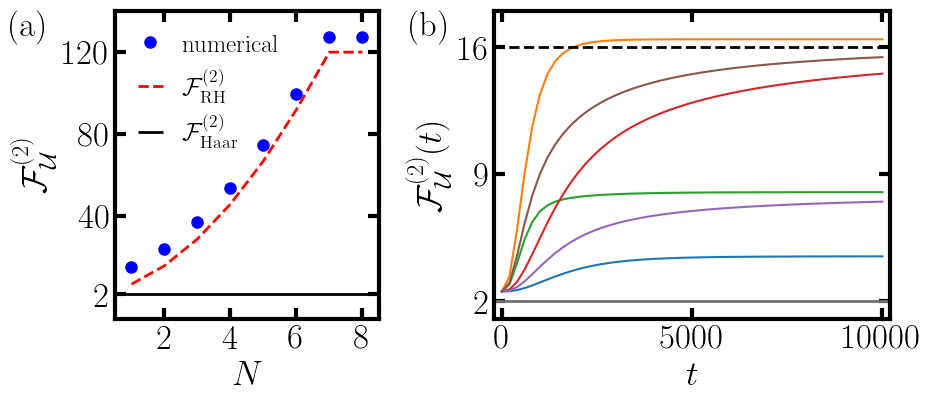

In [8]:
k = 2
steps = int(1e4) + 1
path = 'data/framePot/n2'

Fs_list = [[0.5, 0.7], [1.8, 2.0], [0.5, 2.0], [1, 1], [0.5, 1.0], [1, 2]]
fp_hist = np.zeros((len(Fs_list), 51))
for i in range(len(Fs_list)):
    Fs = Fs_list[i]
    fp_hist[i] = np.load(os.path.join(path, f'RPASpFP{k}hist_n2L64_{Fs[0]}_{Fs[1]}.npy'))

fp2 = np.load('data/framePot/n3/RPASpFP2_n3L128.npy')

fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1.5]})
phases=['\it frozen-kernel', '\it frozen-error', '\it mixed-frozen', '\it critical\: point', 
        '\it critical-frozen-kernel', '\it critical-frozen-error']
for i in range(len(Fs_list)):
    axs[1].plot(np.arange(0, steps, steps//50), fp_hist[i], label=phases[i])
axs[1].hlines(16, xmin=-200, xmax=int(1e4)+200, ls='--', lw=2, color='k')
axs[1].hlines(2, xmin=-200, xmax=int(1e4)+200, lw=2, color='#6E7074')
axs[1].set_xlim(-200, int(1e4) + 200)
axs[1].set_ylim(1, 18)
axs[1].set_yticks([2, 9, 16])
axs[1].set_xlabel(r'$t$')
axs[1].set_ylabel(r'$\mathcal{F}_{\mathcal{U}}^{(2)}(t)$')

axs[0].plot(range(1, 9), fp2, 'o', markersize=8, c='b', label=r'$\rm numerical$')
axs[0].plot(range(1, 9), [2*n**2 + 3*n + 2 if n < 7 else 2*8**2 - 8 for n in range(1, 9)], 
    '--', lw=2, c='r', label=r'$\mathcal{F}_{\rm RH}^{(2)}$')
axs[0].hlines(2, xmin=0, xmax=9, lw=2, color='k', label=r'$\mathcal{F}_{\rm Haar}^{(2)}$')
axs[0].legend(handlelength=1, framealpha=0, fontsize=18)
axs[0].set_ylabel(r'$\mathcal{F}_{\mathcal{U}}^{(2)}$')
axs[0].set_xlabel(r'$N$')
axs[0].set_xlim(0.5, 8.5)
axs[0].set_ylim(-10, 140)
axs[0].set_xticks([2, 4, 6, 8])
axs[0].set_yticks([2, 40, 80, 120])

for i in range(2):
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')
plt.subplots_adjust(wspace=0.35)

fig.text(0.02, 0.82, r'$\rm (a)$')
fig.text(0.42, 0.82, r'$\rm (b)$')

plt.savefig('figures/framePot.svg', bbox_inches='tight')
plt.show()
plt.close()

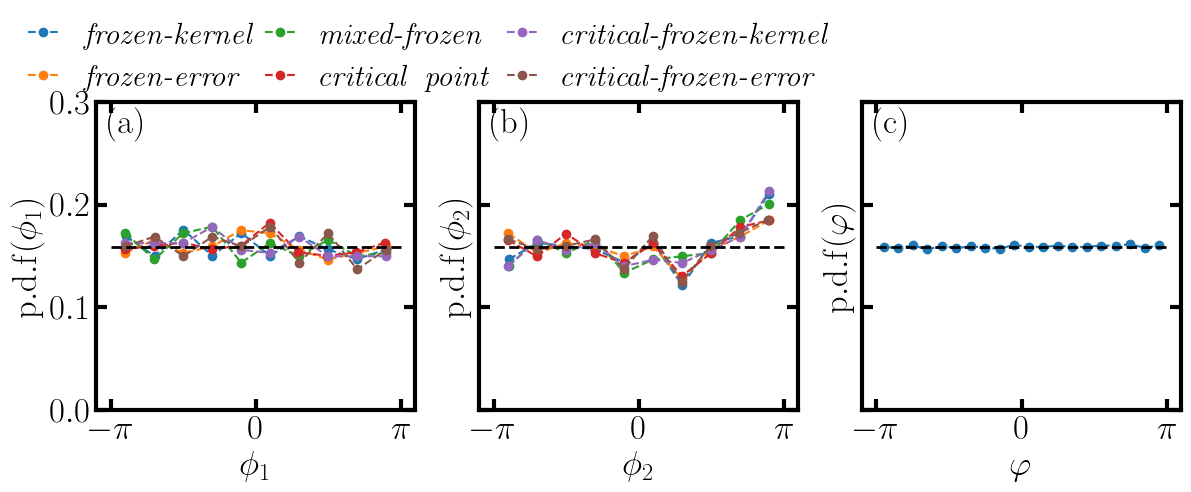

In [160]:
path = 'data/framePot/n2'

np.random.seed(42)
V = unitary_group.rvs(4)

Fs_list = [[0.5, 0.7], [1.8, 2.0], [0.5, 2.0], [1, 1], [0.5, 1.0], [1, 2]]
Us = []

for i in range(len(Fs_list)):
    Fs = Fs_list[i]
    each = np.load(os.path.join(path, f'RPASpUhist_n2L64_{Fs[0]}_{Fs[1]}.npy'))[-1]
    Us.append(contract('aij, jk->aik', each, V))
Us = np.stack(Us)

Us1 = unitary_group.rvs(4, size=500)
Us2 = unitary_group.rvs(4, size=500)
angles = np.angle(contract('aji, bji->ab', Us1.conj(), Us2)).flatten()

fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
phases=['\it frozen-kernel', '\it frozen-error', '\it mixed-frozen', '\it critical\: point', 
        '\it critical-frozen-kernel', '\it critical-frozen-error']
for i in range(len(Fs_list)):
    angles1 = np.angle(Us[i, :, 0, 0])
    angles2 = np.angle(Us[i, :, 1, 1])
    h1, b1 = np.histogram(angles1, bins=10, density=True)
    h2, b2 = np.histogram(angles2, bins=10, density=True)
    axs[0].plot((b1[:-1] + b1[1:])/2, h1, 'o--', label=phases[i])
    axs[1].plot((b2[:-1] + b2[1:])/2, h2, 'o--')
h, b = np.histogram(angles, bins=20, density=True)
axs[2].plot((b[1:] + b[:-1])/2, h, 'o--')
for i in range(3):
    axs[i].plot(np.linspace(-np.pi, np.pi, 100), np.ones(100)/(2*np.pi), '--', c='k', lw=2)
axs[0].set_ylim(0, 0.3)
axs[0].set_xticks([-np.pi, 0, np.pi])
axs[0].set_xticklabels([r'$-\pi$', '$0$', r'$\pi$'])

axs[0].legend(fontsize=22, loc='upper left', bbox_to_anchor=(-0.3, 1.35), ncol=3, framealpha=0, columnspacing=0.5,
    handlelength=1)
for i in range(2):
    axs[i].set_xlabel(fr'$\phi_{i+1}$')
    axs[i].set_ylabel(fr'${{\rm p.d.f}}(\phi_{i+1})$')
axs[2].set_xlabel(r'$\varphi$')
axs[2].set_ylabel(r'${\rm p.d.f}(\varphi)$')

for i in range(3):
    axs[i].tick_params(direction='in', length=8, width=3, top='on', right='on')
    axs[i].text(-3.2, 0.27, fr'$\rm ({chr(97+i)})$')
plt.savefig('figures/angles.pdf', bbox_inches='tight')
plt.show()
plt.close()

In [29]:
ks = [1, 2, 3, 4]

Us_rh = jnp.array(rstU(4, 2, num=10000))

fps = np.zeros(4)
for i in range(4):
    fps[i] = jnp.sum(framePotCal(Us_rh, Us_rh, ks[i]))/len(Us_rh)**2

np.save('data/framePot/n2/rstUFP_n2.npy', fps)

nds = list(range(1, 9))

fps = np.zeros(len(nds))
for i in range(len(nds)):
    Us_rh = jnp.array(rstU(8, nds[i], num=10000))
    fps[i] = jnp.sum(framePotCal(Us_rh, Us_rh, 2))/len(Us_rh)**2

np.save('data/framePot/rstUFP2_n3.npy', fps)

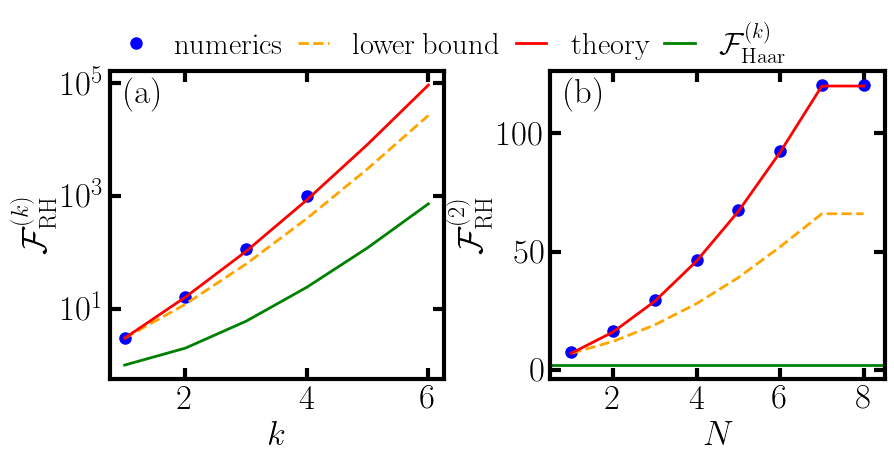

In [189]:
nd = 2
ks = np.arange(1, 5)
kss = np.arange(1, 7)
fp_theory1 = [nd + 1, 8 + 2*nd + nd**2, nd**3 + 3*nd**2 + 24*nd + 36, 
    nd**4 + 4*nd**3 + 48*nd**2 + 144*nd + 318,
    nd**5 + 5*nd**4 + 80*nd**3 + 360*nd**2 + 1590*nd + 2790,
    nd**6 + 6*nd**5 + 120*nd**4 + 720*nd**3 + 4770*nd**2 + 16740*nd + 31040]
lb1 = [framePotLB_rstHaar(2, k, 4) for k in kss]
fps1 = np.load('data/framePot/n2/rstUFP_n2.npy')

nds = list(range(1, 9))
lb2 = [framePotLB_rstHaar(n, 2, 8) for n in nds]
fp_theory2 = [2*n**2 + 3*n + 2 if n < 7 else 2*8**2 - 8 for n in nds]
fps2 = np.load('data/framePot/rstUFP2_n3.npy')

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(ks, fps1, 'o', c='b', markersize=8, label=r'$\rm numerics$')
axs[0].plot(kss, lb1, '--', c='orange', lw=2, label=r'$\rm lower\:bound$')
axs[0].plot(kss, fp_theory1, c='r', lw=2, label=r'$\rm theory$')
axs[0].plot(kss, factorial(kss), c='g', lw=2, label=r'$\mathcal{F}^{(k)}_{\rm Haar}$')

axs[1].plot(nds, fps2, 'o', c='b', markersize=8, label=r'$\rm numerics$')
axs[1].plot(nds, lb2, '--', c='orange', lw=2, label=r'$\rm lower\:bound$')
axs[1].plot(nds, fp_theory2, c='r', lw=2, label=r'$\rm theory$')
axs[1].hlines(2, xmin=0.5, xmax=8.5, lw=2, color='g', label=r'$\mathcal{F}^{(2)}_{\rm Haar}$')

axs[0].set_yscale('log')
axs[0].legend(fontsize=22, handlelength=1, framealpha=0, loc='upper left', bbox_to_anchor=(-0.05, 1.25),
    ncol=4, columnspacing=0.5)
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\mathcal{F}_{\rm RH}^{(k)}$')
axs[1].set_ylabel(r'$\mathcal{F}_{\rm RH}^{(2)}$')
axs[0].set_xlabel(r'$k$')
axs[1].set_xlabel(r'$N$')
axs[0].set_xticks(range(2, 8, 2))
axs[1].set_xlim(0.5, 8.5)
axs[1].set_xticks(range(2, 10, 2))
axs[0].tick_params(direction='in', length=8, width=3, top='on', right='on')
axs[1].tick_params(direction='in', length=8, width=3, top='on', right='on')

fig.text(0.14, 0.8, r'$\rm (a)$')
fig.text(0.58, 0.8, r'$\rm (b)$')

plt.subplots_adjust(wspace=0.32)
plt.savefig('figures/rstFP.pdf', bbox_inches='tight')
plt.show()
plt.close()